In [ ]:
# huggingface + WRIMEデータセット で感情推定

## 環境構築

In [1]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers datasets

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

In [2]:
import numpy as np
import pandas as pd

In [3]:
! pip install datasets==v2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 499.9 kB/s eta 0:00:001m478.6 kB/s eta 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.12.0
    Uninstalling datasets-2.12.0:
      Successfully uninstalled datasets-2.12.0


In [4]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric

### Matplotlibで日本語を使用できるようにする

In [5]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

# NOTE ここで、ランタイムを再起動

zsh:1: command not found: apt-get
rm: /root/.cache/matplotlib/fontlist-v310.json: No such file or directory


Text(0.5, 1.0, '日本語を表示できるかテスト')

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'IPAGothic' not found.
/Users/mariko/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing

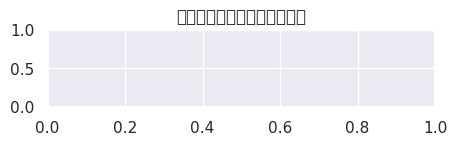

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

## データセットの準備

### WRIMEデータセットのダウンロード

In [7]:
# GitHubよりWRIMEデータをダウンロードする
#
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

--2025-02-09 10:54:05--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
github.com (github.com) をDNSに問いあわせています... 20.27.177.113
github.com (github.com)|20.27.177.113|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [続く]
--2025-02-09 10:54:07--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 9487235 (9.0M) [text/plain]
`wrime-ver1.tsv.1' に保存中

wrime-ver1.tsv.1    100%[===================>]   9.05M  3.53MB/s 時間 2.6s       

2025-02-09 10:54:10 (3.53 MB/s) - `wrime-ver1.tsv.1' へ保存完了 [9487235/9487235]



In [8]:
# 一般的にpandasはpdと名前を付けてimportされる
import pandas as pd
import numpy as np

In [9]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


### 前処理

__前提①：WRIMEデータセットのラベルは、各感情の強度__
- 各感情（例えば、Joy=喜）の強度を、0〜3の４段階でラベル付けしている
- ８つの感情全てにおいて、最頻ラベルは「0」


__前提②：WRIMEデータセットには、複数種類のラベルが付与されている__
1. Writer_*
    - 文章の __書き手__ が自身で付与したラベル。「主観感情」。
2. Reader{1,2,3}_* :
    - 文章の __読み手__ が付与したラベル。「客観感情」。３名分。
3. Avg.Readers_*
    - ３名分の客観感情の平均値。

問題設定
1. ８つの感情の、分類タスクとして扱う
    - 相対的にどの感情が強いかを推定する
    - データセットの本来の用途としては感情強度を推定するタスク。しかしながら、感情強度=0のサンプルが多く、やや扱いが難しいため、今回は簡素化して扱う。
2. 客観感情の平均値を使用する
    - 論文において、主観感情と客観感情は異なることが指摘されている
    - 主観感情は、書き手の性格や表現方法に依存する部分がある。そのため、客観感情、かつ、その平均値を用いることで、推定結果の納得感が高くなることが期待される

In [10]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

# readers_emotion_intensities 列を生成する
# "Avg. Readers_*" の値をlist化したもの
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [11]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


## モデル(BERT)を訓練する

### Tokenizerで入力データに変換

In [12]:
! pip install unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 6.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=3e88916076d7655b2ce8c70c6739dcf022c24a539fe4e1f844b7a66903f34ddb
  Stored in directory: /Users/mariko/Library/Caches/pip/wheels/b7/fd/e9/ea4459b868e6d2902e8d80e82dbacb6203e05b3b3a58c64966
Successfully built unidic_lite


In [13]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

### 訓練済みモデルの読み込み

In [15]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

/Users/mariko/anaconda3/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 訓練を実行

In [16]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

/var/folders/xm/_n_dpsbj29z87lkckg713qd00000gn/T/ipykernel_10674/3063707975.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [17]:
# Transformers の Trainer を用いる
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments

# 訓練時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()

/Users/mariko/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

## 訓練したモデルで推論する

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20170 (\N{CJK UNIFIED IDEOGRAPH-4ECA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph

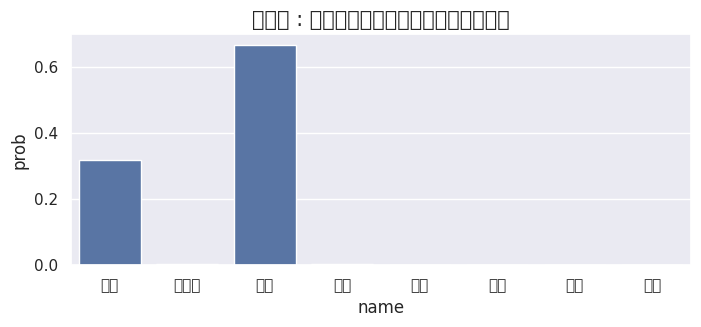

In [27]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

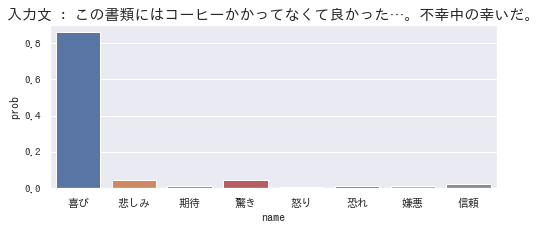

In [ ]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)

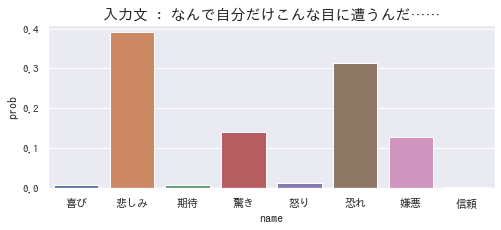

In [ ]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

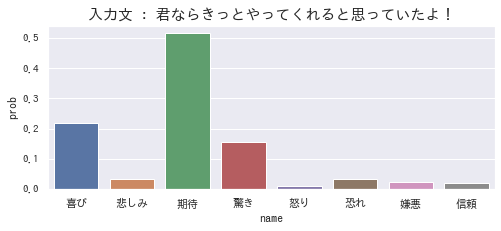

In [ ]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

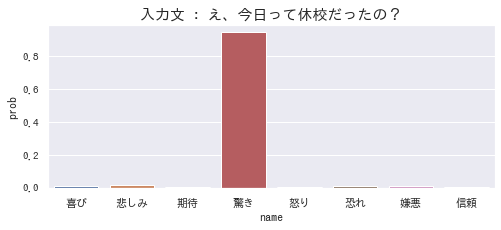

In [ ]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)

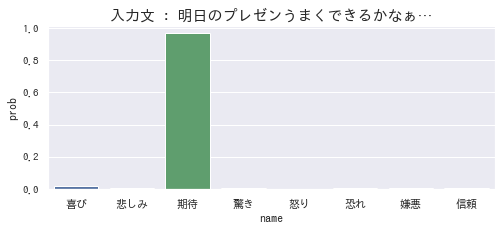

In [ ]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

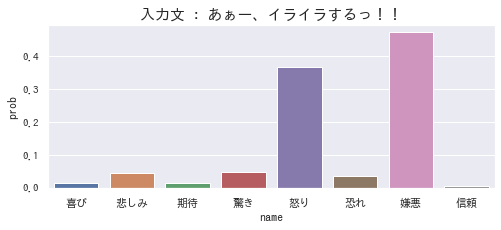

In [ ]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)